In [10]:
# Short-term dynamics of Excitation-Inhibition Balance in Hippocampal CA3-CA1 circuit
# Aditya Asopa, Upinder Singh Bhalla, NCBS
# Publication: https://www.biorxiv.org/content/10.1101/2024.10.30.621034v1
# Imports -----------------------------------------------------------------------------------------------
from   pathlib      import Path
import importlib

import numpy                as np 
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf

from eidynamics.fit_PSC     import find_sweep_expected
import eidynamics.plotFig2 as plotFig2
import eidynamics.stat_annotate as stat_annotate
from eidynamics     import utils, plot_tools

# sns.set_context('paper')
# sns.set_context('paper')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams['svg.fonttype'] = 'none'

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
colors_EI = {-70:flare, 0:crest}

Fs = 2e4
%matplotlib widget
freq_sweep_pulses = np.arange(9)

In [3]:
figure_raw_material_location = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\paper_figures\submission")
paper_figure_export_location = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\paper_figures\submission")
data_path_FS                 = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\FreqSweep")
data_path_grid               = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\Grid")
data_path_analysed           = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\second_order")

# Load Data

In [4]:
VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(r"parsed_data\FreqSweep\all_cells_FreqSweep_VC_short.h5", key='data')
cc_FS_shortdf = pd.read_hdf(r"parsed_data\FreqSweep\all_cells_FreqSweep_CC_short.h5", key='data')
print(vc_FS_shortdf.shape, cc_FS_shortdf.shape)

(4407, 49) (4971, 49)


In [5]:
# September 2024
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# short data path for all protocols.
# Does not contain kernel fit measurements and does not contain screening parameters. Only use for other protocols.
# 18Sep24
dfshortpath     = data_path_analysed / "all_cells_allprotocols_with_fpr_values.h5"
xc_all_shortdf  = pd.read_hdf(dfshortpath, key='data')
print(xc_all_shortdf.shape)

# the long dataset (don't load yet)
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5" 
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"

(4971, 163)
(4407, 163)
(16870, 63)


In [6]:
# CC data screening based on dataflag_fields
cc_FS_shortdf_slice = cc_FS_shortdf[
            (cc_FS_shortdf['location'] == 'CA1') &
            (cc_FS_shortdf['numSq'].isin([1,5,15])) &
            (cc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (cc_FS_shortdf['condition'] == 'Control') &
            (cc_FS_shortdf['ch0_response']==1) &
            (cc_FS_shortdf['IR'] >50) & (cc_FS_shortdf['IR'] < 300) &
            (cc_FS_shortdf['tau'] < 40) & 
            (cc_FS_shortdf['intensity'] == 100) &
            (cc_FS_shortdf['pulseWidth'] == 2) &
            (cc_FS_shortdf['spike_in_baseline_period'] == 0) &
            (cc_FS_shortdf['ac_noise_power_in_ch0'] < 40) 
            # (cc_FS_shortdf['valley_0'].notnull())
        ]
print(cc_FS_shortdf.shape, '--screened-->', cc_FS_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { cc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {cc_FS_shortdf_slice['trialID'].nunique()}")

# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure2_screened_trialIDs_CC_FS.txt", screened_cc_trialIDs, fmt='%s')

(4971, 163) --screened--> (2201, 163)
Unique cells in screened data: 16
Unique sweeps in screened data: 2201


In [7]:
# VC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            (vc_FS_shortdf['intensity'] == 100) &
            (vc_FS_shortdf['pulseWidth'] == 2) &
            (vc_FS_shortdf['probePulseStart']==0.2) &
            (vc_FS_shortdf['IR'] >50) & (vc_FS_shortdf['IR'] < 300) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)&
            (vc_FS_shortdf['valley_0'].notnull())
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# save the screened trialIDs
# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure2_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

(4407, 163) --screened--> (928, 163)


Unique cells in screened data: 6
Unique sweeps in screened data: 928


In [8]:
# combine short dataframes slice and delete the original ones
xc_FS_shortdf_slice = pd.concat([cc_FS_shortdf_slice, vc_FS_shortdf_slice], axis=0)
del cc_FS_shortdf, vc_FS_shortdf
del cc_FS_shortdf_slice, vc_FS_shortdf_slice

In [9]:
### Load the Longform data and keep the screened trials only to save space
# load the data
cc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_CC_long.h5"
cc_FS_longdf = pd.read_hdf(cc_FS_datapath, key='data')

cc_FS_longdf_slice = cc_FS_longdf[ cc_FS_longdf['trialID'].isin(screened_cc_trialIDs) ]
print('CC: ', cc_FS_longdf.shape, '--screened-->', cc_FS_longdf_slice.shape)
del cc_FS_longdf

# load the data
vc_FS_datapath =  data_path_FS / "all_cells_FreqSweep_VC_long.h5"
vc_FS_longdf = pd.read_hdf(vc_FS_datapath, key='data')

vc_FS_longdf_slice = vc_FS_longdf[ vc_FS_longdf['trialID'].isin(screened_vc_trialIDs) ]
print('VC: ', vc_FS_longdf.shape, '--screened-->', vc_FS_longdf_slice.shape)
del vc_FS_longdf

xc_FS_longdf_slice = pd.concat([cc_FS_longdf_slice, vc_FS_longdf_slice])
del cc_FS_longdf_slice, vc_FS_longdf_slice

CC:  (4971, 80073) --screened--> (2201, 80073)
VC:  (4407, 80073) --screened--> (928, 80073)


# Setup figure2

data shape: (2047, 163)


c:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:678: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


## Unique values of: numSq: 3, stimFreq: 4, patterns: 53, pulses: 9

## Stat test on normalized PSP response 
                   sum_sq       df          F        PR(>F)
C(cellID)    2475.855369     15.0  19.421106  9.490564e-53
numSq          95.624543      1.0  11.251471  7.971137e-04
pulse         109.393395      1.0  12.871556  3.344301e-04
stimFreq      108.404749      1.0  12.755229  3.558690e-04
Residual   165897.513902  19520.0        NaN           NaN
data shape: (154, 164)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_23404\3106613190.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)
c:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:678: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


## Unique values of: numSq: 2, stimFreq: 4, patterns: 8, pulses: 9

## Stat test on Spike Likelihood 
                sum_sq      df           F        PR(>F)
C(cellID)   31.748252     3.0   64.031088  9.250368e-39
numSq       32.219201     1.0  194.942745  1.545672e-41
pulse       51.227706     1.0  309.953982  9.681182e-63
stimFreq     1.054539     1.0    6.380502  1.164929e-02
Residual   227.914498  1379.0         NaN           NaN
[4000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000] 20 421 -300.0015 0.2 0.5 1000 (4000,) [-96.36308274   0.09727707]
[4000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000] 20 491 940.26776 0.2 0.5 1000 (4000,) [6.03936532e+02 1.33254868e-01]
data shape: (529, 163)


c:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:678: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


data shape: (399, 163)


c:\Users\Aditya\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\eidynamics\plot_tools.py:678: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  Fig.subplots_adjust(hspace=0.5, wspace=0.5)


## Unique values of: numSq: 3, stimFreq: 4, patterns: 53, pulses: 9

## Stat test on normalized PSC response 
                         sum_sq      df           F        PR(>F)
C(cellID)           256.159054     5.0   48.682195  7.790558e-50
C(clampPotential)    34.492044     1.0   32.775504  1.070225e-08
numSq                27.162414     1.0   25.810642  3.847700e-07
pulse               200.243514     1.0  190.278142  8.141180e-43
stimFreq             24.446915     1.0   23.230284  1.462550e-06
Residual           8778.892681  8342.0         NaN           NaN


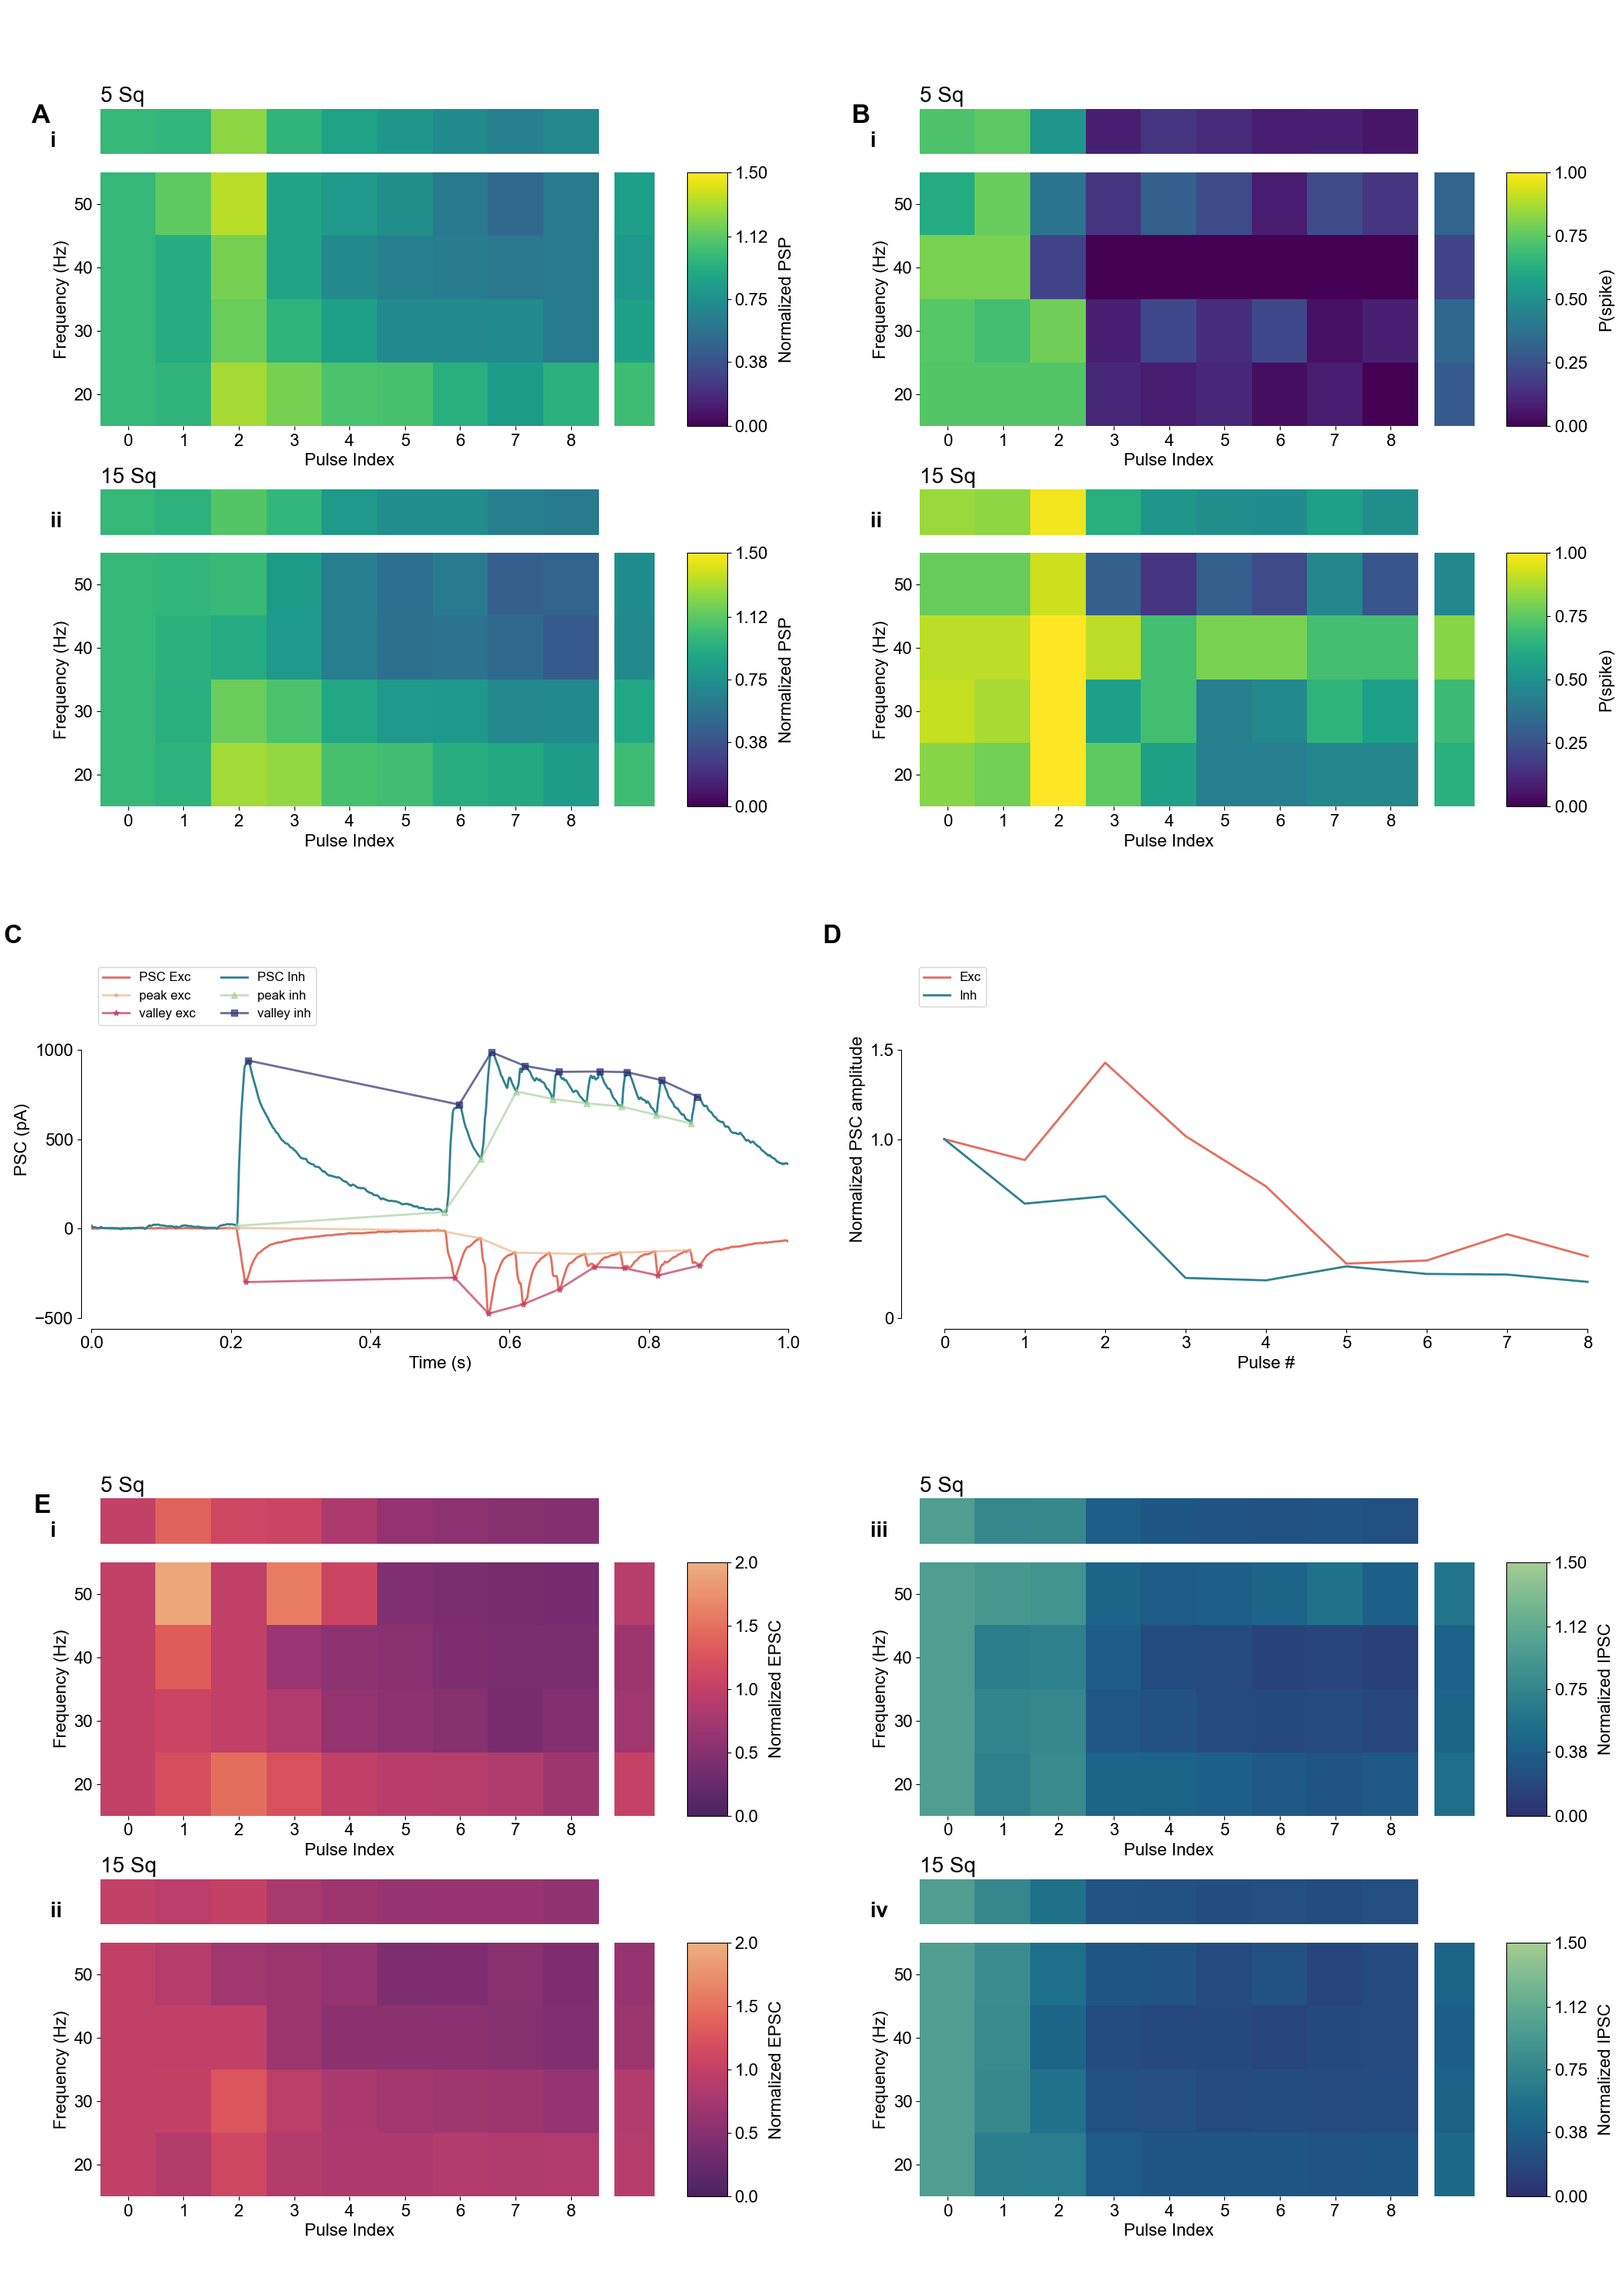

In [19]:
# Setup the figure
w,h = 21, 29.7   
fig = plt.figure(layout='constrained', figsize=(w,h))

[Fig2Top, Fig2Mid, Fig2Bottom] = fig.subfigures(3,1, wspace=0.03, hspace=0.02, height_ratios=[2, 1, 2])

[subfigsA, subfigsB] = Fig2Top.subfigures(1,2)
[subfigsC, subfigsD] = Fig2Mid.subfigures(1,2)
[subfigsE1, subfigsE2] = Fig2Bottom.subfigures(1,2)

# [ax2Ai, ax2Aii] = subfigsA.subplots(2,1)
# [ax2Bi, ax2Bii] = subfigsB.subplots(2,1)
ax2C = subfigsC.subplots(1,1)
ax2D = subfigsD.subplots(1,1)
# [[ax2Ei, ax2Eii],[ax2Eiii, ax2Eiv]] = Fig2Bottom.subplots(2,2)

# get location of subfigsA in the main figure
# subfigsA_pos = subfigsA.get_position()
## -----------------------------------------------------------------------------------------------
# Fig2A: CC heatmap of normPSC
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
f,a = plot_tools.plot_response_heatmaps(dftemp[dftemp['AP']==0], feature='normPSC_', Fig=subfigsA, figlabels=['i','ii'], clampMode='CC', heatmap_palette={-70:'viridis'}, cbar_limits=[0,1.5], annot=False)
a[0][-1].set_label('Normalized PSP', rotation=90, labelpad=10)
a[1][-1].set_label('Normalized PSP', rotation=90, labelpad=10)
a[0][1].text(-0.1, 1.1, 'A', transform=a[0][1].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
# Load the data for stat
to_plot = [f'normPSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( dftemp, id_vars=['cellID','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))
# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)
print(f'## Unique values of: numSq: {df_melt["numSq"].nunique()}, stimFreq: {df_melt["stimFreq"].nunique()}, patterns: {df_melt["patternList"].nunique()}, pulses: {df_melt["pulse"].nunique()}')
model = ols('peak_response ~ C(cellID) + numSq + pulse + stimFreq ', data=df_melt).fit()
# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print('\n## Stat test on normalized PSP response', '\n',anova_table)

## -----------------------------------------------------------------------------------------------
# spike likelihood heatmap
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)
dftemp= dftemp[(dftemp['AP']==1) ]
f,a = plot_tools.plot_response_heatmaps(dftemp, feature='spike_', Fig=subfigsB, figlabels=['i','ii'], clampMode='CC', heatmap_palette={-70:'viridis'}, annot=False, cbar_limits=[0,1])
a[0][-1].set_label('P(spike)', rotation=90, labelpad=10)
a[1][-1].set_label('P(spike)', rotation=90, labelpad=10)
a[0][1].text(-0.1, 1.1, 'B', transform=a[0][1].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
# Load the data
to_plot = [f'spike_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( dftemp, id_vars=['cellID','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)
# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))
print(f'## Unique values of: numSq: {df_melt["numSq"].nunique()}, stimFreq: {df_melt["stimFreq"].nunique()}, patterns: {df_melt["patternList"].nunique()}, pulses: {df_melt["pulse"].nunique()}')
# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)
model = ols('peak_response ~ C(cellID) + numSq + pulse + stimFreq ', data=df_melt).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print('\n## Stat test on Spike Likelihood', '\n', anova_table)

# add panel label



## -----------------------------------------------------------------------------------------------
# Fig2C: Upi's fitting of the kernel for both E and I
ax2C.text(-0.1, 1.1, 'C', transform=ax2C.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
cell = 7492
pattern = 52
trial = 0 # or 1
exc_sweep = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==cell) & (xc_FS_longdf_slice['patternList']==pattern) & (xc_FS_longdf_slice['clampPotential']==-70)& (xc_FS_longdf_slice['stimFreq']==20)]
inh_sweep = xc_FS_longdf_slice[(xc_FS_longdf_slice['cellID']==cell) & (xc_FS_longdf_slice['patternList']==pattern) & (xc_FS_longdf_slice['clampPotential']==0)  & (xc_FS_longdf_slice['stimFreq']==20)]

row = exc_sweep.iloc[0, :]
_,_, npv_exc, _ = exc_results = plotFig2.deconv(row[49:80049], row['stimFreq'], row['probePulseStart'], row['pulseTrainStart'], None, noprobepulse=(row['probePulseStart']==0.5))
valley_times = npv_exc[0]
peak_times = npv_exc[3]
ax2C.plot(np.linspace(0,1,20000), row[49:20049], color='#e46d5dff', label='PSC Exc')
ax2C.plot(npv_exc[0], npv_exc[1], color='#ecab7d9d', marker=".", linewidth=2, label='peak exc')
ax2C.plot(npv_exc[2], npv_exc[3], color='#c23f69bf', marker="*", linewidth=2, label='valley exc')

row = inh_sweep.iloc[0, :]
_,_, npv_inh, _ = inh_results = plotFig2.deconv(row[49:80049], row['stimFreq'], row['probePulseStart'], row['pulseTrainStart'], None, noprobepulse=(row['probePulseStart']==0.5))
valley_times = npv_inh[0]
peak_times = npv_inh[3]
ax2C.plot(np.linspace(0,1,20000), row[49:20049], color='#2f818dff', label='PSC Inh')
ax2C.plot(npv_inh[0], npv_inh[1], color='#9dca929a', marker="^", linewidth=2, label='peak inh')
ax2C.plot(npv_inh[2], npv_inh[3], color='#2c3071b3', marker="s", linewidth=2, label='valley inh')

#cosmetics
ax2C.set_xlabel('Time (s)')
ax2C.set_ylabel('PSC (pA)')
ax2C.set_xlim([0,1])
ax2C.set_ylim([-500,1500])
ax2C.set_xticks(np.linspace(0,1.0,6, endpoint=True))
ax2C.set_yticks([-500, 0, 500, 1000])
ax2C.legend(loc='upper left', fontsize=12, ncols=2)
sns.despine(ax=ax2C, top=True, right=True, trim=True, offset=10)

## -----------------------------------------------------------------------------------------------
# Fig2D: E and I kernel fits
ax2D.text(-0.1, 1.1, 'D', transform=ax2D.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
ax2D.plot(range(9), exc_results[0], linewidth=2, color='#e46d5dff', label='Exc')
ax2D.plot(range(9), inh_results[0], linewidth=2, color='#2f818dff', label='Inh')
#cosmetics
ax2D.set_xticks(range(9))
ax2D.set_xticklabels(range(9))
ax2D.set_yticks([0, 1.0, 1.5])
ax2D.set_yticklabels([0, 1.0, 1.5])
ax2D.set_ylim([0, 2.0])
ax2D.set_xlabel('Pulse #')
ax2D.set_ylabel('Normalized PSC amplitude')
ax2D.legend(loc='upper left', fontsize=12)
# despine
sns.despine(ax=ax2D, top=True, right=True, trim=True, offset=10)
## -----------------------------------------------------------------------------------------------
# Fig2E: VC heatmap of normPSC
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
f,a = plot_tools.plot_response_heatmaps(dftemp[dftemp['clampPotential']==-70], feature='normPSC_', Fig=subfigsE1, figlabels=['i','ii'], clampMode='VC', annot=False, cbar_limits=[0,2.0])
a[0][1].text(-0.1, 1.1, 'E', transform=a[0][1].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
a[0][-1].set_label('Normalized EPSC', rotation=90, labelpad=10)
a[1][-1].set_label('Normalized EPSC', rotation=90, labelpad=10)

dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
f,a = plot_tools.plot_response_heatmaps(dftemp[dftemp['clampPotential']==0], feature='normPSC_', Fig=subfigsE2, figlabels=['iii', 'iv'], clampMode='VC', annot=False, cbar_limits=[0,1.5])
a[0][-1].set_label('Normalized IPSC', rotation=90, labelpad=10)
a[1][-1].set_label('Normalized IPSC', rotation=90, labelpad=10)

dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
to_plot = [f'normPSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( dftemp, id_vars=['cellID','clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))
# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

print(f'## Unique values of: numSq: {df_melt["numSq"].nunique()}, stimFreq: {df_melt["stimFreq"].nunique()}, patterns: {df_melt["patternList"].nunique()}, pulses: {df_melt["pulse"].nunique()}')
model = ols('peak_response ~ C(cellID) + C(clampPotential) + numSq + pulse + stimFreq ', data=df_melt).fit()
# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print('\n## Stat test on normalized PSC response', '\n', anova_table)
## -----------------------------------------------------------------------------------------------
# go through all the texts in the figure panels and change the fontsize to 20


## -----------------------------------------------------------------------------------------------
# save fig
figname = 'Figure2'
fig.savefig(paper_figure_export_location / f"{figname}.svg", format='svg', dpi=300)
fig.savefig(paper_figure_export_location / f"{figname}.png", format='png', dpi=300)
fig.savefig(paper_figure_export_location / f"{figname}.pdf", format='pdf', dpi=300)

In [13]:
a[1]

(<Axes: title={'left': '15 Sq'}, xlabel='Pulse Index', ylabel='Frequency (Hz)'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Normalized IPSC'>,
 <matplotlib.colorbar.Colorbar at 0x17989000a10>)

## ANOVA for PSC response

In [ ]:
dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='VC')]
print(dftemp.shape)
to_plot = [f'normPSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( dftemp, id_vars=['cellID','clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
# clampPotential =0 if 0, 1 if -70
# df_melt['clampPotential'] = df_melt['clampPotential'].apply(lambda x: 1 if x==-70 else 0)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))
# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

model = ols('peak_response ~ C(cellID) + C(clampPotential) + numSq + pulse + stimFreq ', data=df_melt).fit()
print(model.summary())
# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print('Stat test on normalized PSC response', '\n',anova_table)

print('### ANOVA between early pulses and late pulses in the train')
# phase 0 if pulse is less than 5 else phase is 1
df_melt['phase'] = df_melt['pulse'].apply(lambda x: 0 if x < 5 else 1)
model2 = ols('peak_response ~ C(cellID) + numSq + pulse + stimFreq ', data=df_melt).fit()

# Perform ANOVA
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print(anova_table2)

dftemp = xc_FS_shortdf_slice[(xc_FS_shortdf_slice['clampMode']=='CC')]
dftemp['numspikes'] = dftemp[[f'spike_{i}' for i in range(9)]].sum(axis=1)
dftemp= dftemp[(dftemp['AP']==1) ]

print('### significance across frequencies')
# kruskal test across freqs
kruskal_stat, pval = kruskal(*[df_melt[df_melt['stimFreq']==i]['peak_response'] for i in [20,30,40,50]])
print(kruskal_stat, pval)

print('### significance across numSq')
# kruskal test across numSq
kruskal_stat, pval = kruskal(*[df_melt[df_melt['numSq']==i]['peak_response'] for i in [5,15]])
print(kruskal_stat, pval)

(928, 163)
(8352, 7)
                            OLS Regression Results                            
Dep. Variable:          peak_response   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     82.58
Date:                Fri, 18 Oct 2024   Prob (F-statistic):          1.58e-147
Time:                        18:00:01   Log-Likelihood:                -12059.
No. Observations:                8352   AIC:                         2.414e+04
Df Residuals:                    8342   BIC:                         2.421e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Interce

## ANOVA for spike likelihood

In [ ]:
# y value is 'AP' 
to_plot = [f'spike_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( dftemp, id_vars=['cellID','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))
# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

# model
model_spike = ols('peak_response ~ C(cellID) + numSq + pulse + stimFreq ', data=df_melt).fit()
# Perform ANOVA
anova_table_spike = sm.stats.anova_lm(model_spike, typ=2)
print(anova_table_spike)

print('### ANOVA between early pulses and late pulses in the train')
# pool data across pulses as phase and check again
df_melt['phase'] = df_melt['pulse'].apply(lambda x: 0 if x < 5 else 1)
model_spike2 = ols('peak_response ~ C(cellID) + numSq + phase + stimFreq ', data=df_melt).fit()

# Perform ANOVA
anova_table_spike2 = sm.stats.anova_lm(model_spike2, typ=2)
print(anova_table_spike2)

print('### significance across frequencies')
# kruskal test across freqs
kruskal_stat, pval = kruskal(*[df_melt[df_melt['stimFreq']==i]['peak_response'] for i in [20,30,40,50]])
print(kruskal_stat, pval)

print('### significance across numSq')
# kruskal test across numSq
kruskal_stat, pval = kruskal(*[df_melt[df_melt['numSq']==i]['peak_response'] for i in [5,15]])
print(kruskal_stat, pval)

(1386, 6)
               sum_sq      df           F        PR(>F)
C(cellID)   31.748252     3.0   64.031088  9.250368e-39
numSq       32.219201     1.0  194.942745  1.545672e-41
pulse       51.227706     1.0  309.953982  9.681182e-63
stimFreq     1.054539     1.0    6.380502  1.164929e-02
Residual   227.914498  1379.0         NaN           NaN
